# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [3]:
!pip install -qU ragas==0.2.10

In [2]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 6.5 MB/s eta 0:00:00
   ━━━━

In [4]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


We'll also want to set a project name to make things easier for ourselves.

In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [7]:
!mkdir data

In [8]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31314    0 31314    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k


In [9]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70173    0 70173    0     0   410k      0 --:--:-- --:--:-- --:--:--  412k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [11]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()
print(docs)

[Document(metadata={'source': 'data/2024_llms.html'}, page_content='Simon Willison’s Weblog\n\nSubscribe\n\nThings we learned about LLMs in 2024\n\n31st December 2024\n\nA lot has happened in the world of Large Language Models over the course of 2024. Here’s a review of things we figured out about the field in the past twelve months, plus my attempt at identifying key themes and pivotal moments.\n\nThis is a sequel to my review of 2023.\n\nIn this article:\n\nThe GPT-4 barrier was comprehensively broken\n\nSome of those GPT-4 models run on my laptop\n\nLLM prices crashed, thanks to competition and increased efficiency\n\nMultimodal vision is common, audio and video are starting to emerge\n\nVoice and live camera mode are science fiction come to life\n\nPrompt driven app generation is a commodity already\n\nUniversal access to the best models lasted for just a few short months\n\n“Agents” still haven’t really happened yet\n\nEvals really matter\n\nApple Intelligence is bad, Apple’s MLX 

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [13]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [14]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [15]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 71)

We can save and load our knowledge graphs as follows.

In [16]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 71)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [18]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


#### ✅ Answer #1:
Each of these query synthesizers is generating search queries for an information retrieval system, but they do so in different ways:

1. **SingleHopSpecificQuerySynthesizer** (50% weight)  
   - This synthesizer generates a single, direct query based on the given input.  
   - It focuses on **specific details** and aims to retrieve relevant documents in one step.  
   - Example: If the input is *"What is the capital of France?"*, it would directly query *"capital of France"*.  

2. **MultiHopAbstractQuerySynthesizer** (25% weight)  
   - This one breaks down complex queries into multiple steps but formulates them in a **more general or abstract** way.  
   - It helps in cases where background knowledge is needed before answering the main question.  
   - Example: If asked *"How did the capital of France influence European politics in the 18th century?"*, it might first generate a query like *"Political influence of capitals in the 18th century"* before refining it to focus on Paris.  

3. **MultiHopSpecificQuerySynthesizer** (25% weight)  
   - Similar to the multi-hop abstract version, but it generates **specific** multi-step queries instead of broad ones.  
   - It refines the search iteratively by pulling precise details from each step.  
   - Example: For *"How did the capital of France influence European politics in the 18th century?"*, it might first query *"Paris in the 18th century"*, then use that result to generate a second query like *"Parisian political influence in Europe during the 18th century"*.  

### Conclusion:
- **SingleHopSpecific** → Direct, single-step, precise queries.  
- **MultiHopAbstract** → Multi-step, generalized queries to gather broad context first.  
- **MultiHopSpecific** → Multi-step, precise queries that progressively refine the search.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [19]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What new features does Gemini 1.5 Pro have?,[Prompt driven app generation is a commodity a...,Gemini 1.5 Pro introduced several brand new ca...,single_hop_specifc_query_synthesizer
1,What are the recent advancements in Amazon Nov...,"[gets you OpenAI’s most expensive model, o1. G...",Amazon pre-announced voice mode for Amazon Nov...,single_hop_specifc_query_synthesizer
2,What recent advancements have been made with G...,[feed with the model and talk about what you c...,Google Gemini has introduced a preview of real...,single_hop_specifc_query_synthesizer
3,What role does Vercel play in the context of p...,[dependent on AGI itself. A model that’s robus...,Vercel's Malte Ubl mentioned that when @v0 fir...,single_hop_specifc_query_synthesizer
4,Claude 3.5 Sonnet good or not?,[that. DeepSeek v3 is a huge 685B parameter mo...,Benchmarks put DeepSeek v3 up there with Claud...,single_hop_specifc_query_synthesizer
5,What are the challenges and advancements in th...,[<1-hop>\n\nCode may be the best application T...,The development and usage of Large Language Mo...,multi_hop_abstract_query_synthesizer
6,How does the concept of 'Vibes Based Developme...,[<1-hop>\n\nCode may be the best application T...,The concept of 'Vibes Based Development' relat...,multi_hop_abstract_query_synthesizer
7,How do the challenges of LLMs as black boxes i...,[<1-hop>\n\nCode may be the best application T...,The challenges of LLMs as black boxes signific...,multi_hop_abstract_query_synthesizer
8,In the context of advancements in Large Langua...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"In 2023, Large Language Models (LLMs) experien...",multi_hop_specific_query_synthesizer
9,How has the introduction of GPT-4o and its pri...,[<1-hop>\n\ngets you OpenAI’s most expensive m...,"The introduction of GPT-4o, which is significa...",multi_hop_specific_query_synthesizer


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('synthesizer_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('synthesizer_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('synthesizer_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='synthesizer_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['synthesizer_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='index', y='synthesizer_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [20]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What advancements did Google introduce with th...,[Prompt driven app generation is a commodity a...,"Google's Gemini 1.5 Pro, released in February ...",single_hop_specifc_query_synthesizer
1,How has Google's Gemini 1.5 Flash model contri...,"[gets you OpenAI’s most expensive model, o1. G...",Google's Gemini 1.5 Flash model has significan...,single_hop_specifc_query_synthesizer
2,what is webrtc api?,[feed with the model and talk about what you c...,"OpenAI announced a new WebRTC API in December,...",single_hop_specifc_query_synthesizer
3,who amanda askell and what she say about evals?,[dependent on AGI itself. A model that’s robus...,Amanda Askell is associated with Anthropic and...,single_hop_specifc_query_synthesizer
4,How has the environmental impact of AI models ...,[<1-hop>\n\nPrompt driven app generation is a ...,The environmental impact of AI models has seen...,multi_hop_abstract_query_synthesizer
5,How has the environmental impact of AI models ...,[<1-hop>\n\nPrompt driven app generation is a ...,The environmental impact of AI models has impr...,multi_hop_abstract_query_synthesizer
6,How has the environmental impact of AI models ...,[<1-hop>\n\nPrompt driven app generation is a ...,The environmental impact of AI models has seen...,multi_hop_abstract_query_synthesizer
7,How has the environmental impact of AI models ...,[<1-hop>\n\nPrompt driven app generation is a ...,The environmental impact of AI models has seen...,multi_hop_abstract_query_synthesizer
8,How do the advancements in GPT-4o and its pric...,[<1-hop>\n\nAnother common technique is to use...,GPT-4o is significantly cheaper and more capab...,multi_hop_specific_query_synthesizer
9,How has the development of Claude 3 and its su...,[<1-hop>\n\nPrompt driven app generation is a ...,The development of Claude 3 and its subsequent...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [22]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years - v2"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years v2"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [23]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [24]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [26]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [27]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [28]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [29]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [31]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [32]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents refer to AI systems that can act on your behalf, but the term is vague and lacks a clear, widely understood definition. There are two main interpretations: one views agents as entities that perform tasks like a travel agent, while the other sees them as LLMs (Large Language Models) that use tools to solve problems. Despite being a popular concept, there are few examples of them in production, and their development is hindered by issues such as gullibility and the need for robustness, often depending on the achievement of AGI (Artificial General Intelligence).'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [33]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [34]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

#### ✅ Activity Answer #2:
Here’s what each evaluator is assessing:  

- **`qa_evaluator`** → Evaluates the **accuracy** of the generated answer compared to a correct reference answer.  

- **`labeled_helpfulness_evaluator`** → Measures the **helpfulness** of the response by checking if it effectively assists the user while considering the correct reference answer.  

- **`dope_or_nope_evaluator`** → Judges the **"dopeness"** (i.e., whether the response is cool, engaging, or lit) based on subjective style and appeal.  


## LangSmith Evaluation

In [35]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'memorable-pump-97' at:
https://smith.langchain.com/o/8a88797e-5f0c-4143-8820-5e498815cee3/datasets/c9ca966d-e4a6-414f-bc07-5b3d3154f249/compare?selectedSessions=df0f3496-a17f-44e6-b708-516d10518c73




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does the development of Claude's character...,The development of Claude's character by Anthr...,None,The development of Claude's character by Anthr...,1,1,0,2.478700,07ea1670-0d67-4eaf-b1b5-24bb5f3518ab,b4aad6cb-ba11-46a7-8885-9882ee4c5bdd
1,How has the environmental impact of training l...,The environmental impact of training large lan...,None,The environmental impact of training large lan...,0,0,0,2.604138,aeafd5da-9384-4890-86e8-8fa5c1cd7fc6,5ef88753-5bb7-4f60-9b11-574162ceda81
2,How has the development of Claude 3 and its su...,I don't know.,None,The development of Claude 3 and its subsequent...,0,0,0,0.636830,9474d3ed-11b9-44a7-a372-32bd776418a7,503fd365-49a1-4479-862c-f8c2fd670475
3,How do the advancements in GPT-4o and its pric...,The advancements in GPT-4o show significant im...,None,GPT-4o is significantly cheaper and more capab...,1,0,0,3.961320,8e11373a-cea0-411d-8c4f-649dfef2b22b,177c309b-32cc-4051-96ed-98840c8bd9a6
4,How has the environmental impact of AI models ...,The environmental impact of AI models has show...,None,The environmental impact of AI models has seen...,1,1,0,3.050005,3b860113-39e3-40b0-9cdd-804ffb1e3417,ad27c717-6e35-4f0f-8f01-e008c732842c
5,How has the environmental impact of AI models ...,The environmental impact of AI models has evol...,None,The environmental impact of AI models has seen...,1,0,0,2.944710,56f370bc-8043-426b-8c12-921e2fbf565e,79c25534-34b0-4731-9a65-bcd3c1730321
6,How has the environmental impact of AI models ...,The environmental impact of AI models has impr...,None,The environmental impact of AI models has impr...,1,0,1,2.103454,b40aedb9-2483-4b9f-9e99-a91e494ac9e6,9de9c6a4-504d-4dee-9365-3ede40610918
7,How has the environmental impact of AI models ...,The environmental impact of AI models has show...,None,The environmental impact of AI models has seen...,1,0,0,3.917538,3a6a995f-878e-48da-8585-ec035bfa0b80,8fd502ca-ad65-4435-b0dd-6ebf0cb07cde
8,who amanda askell and what she say about evals?,Amanda Askell is associated with Anthropic and...,None,Amanda Askell is associated with Anthropic and...,1,1,0,1.989512,45df7ba1-882e-40d2-94e7-924a2efac4cd,29b523ef-697a-4a6c-a5df-cac2b03a58bd
9,what is webrtc api?,I don't know.,None,"OpenAI announced a new WebRTC API in December,...",0,0,0,0.703323,8332af13-0fd1-49e6-ae2c-e22e66094f6a,ab52c4c1-6ff0-45bc-ac66-54df67962713


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [36]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [37]:
rag_documents = docs

In [38]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

#### ✅ Answer #2: Modifying the **chunk size** in `RecursiveCharacterTextSplitter` impacts the performance of your **RAG (Retrieval-Augmented Generation) application** in several key ways:

---

### **1. Retrieval Quality & Context Retention**  
- **Smaller chunks (e.g., 500 tokens)** → More focused search results but may lack full context.  
- **Larger chunks (e.g., 2000 tokens)** → More context in each chunk but may retrieve unnecessary information.  
- **Impact:** If chunks are too small, important context might be lost, leading to **incomplete** or **incorrect** responses. If too large, the model might retrieve **irrelevant** data.  

---

### **2. Efficiency & Latency**  
- **Smaller chunks** → More chunks stored → **More retrieval operations** (higher latency).  
- **Larger chunks** → Fewer chunks stored → **Less retrieval overhead**, but each chunk is **heavier** to process.  
- **Impact:** A balance is needed to optimize retrieval speed without overloading the system.  

---

### **3. Token Limits & Model Constraints**  
- LLMs have a **context window limit** (e.g., GPT-4: ~8K–32K tokens).  
- **Large chunks may exceed token limits**, forcing truncation and reducing effectiveness.  
- **Impact:** Smaller chunks ensure responses fit within limits, but if they are too small, the model might miss key details.  

---

### **4. Overlap & Redundancy**  
- **Chunk overlap (e.g., 50 tokens)** helps maintain continuity across chunks.  
- **Too much overlap (e.g., 500 tokens)** → Increased redundancy → Higher storage & retrieval costs.  
- **Too little overlap (e.g., 10 tokens)** → Chunks may lose essential linking information.  
- **Impact:** A well-balanced **chunk overlap** ensures smooth context transition without excessive redundancy.  

---

### **5. Indexing & Storage Considerations**  
- **Smaller chunks** → **More index entries**, increasing search precision but requiring **more storage**.  
- **Larger chunks** → **Fewer index entries**, reducing overhead but making retrieval less granular.  
- **Impact:** Storage and query performance must be balanced based on the dataset size and expected query complexity.  

---

### ** Some Best Practices for Chunk Size in RAG**  
| **Use Case** | **Recommended Chunk Size** | **Why?** |  
|-------------|----------------------|--------|  
| **Short, factual Q&A** | 300–600 tokens | Precise retrieval, avoids excess data |  
| **General search (balanced approach)** | 800–1200 tokens | Good mix of context & efficiency |  
| **Summarization or open-ended queries** | 1500–2000 tokens | Ensures full context for the model |  


In [39]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

#### ✅ Answer #3:

Modifying the **embedding model** affects your application's **retrieval accuracy, speed, and cost**:  

- **Larger models (e.g., `text-embedding-3-large`)** → More accurate embeddings, better semantic understanding, but **higher latency & cost**.  
- **Smaller models (e.g., `text-embedding-3-small`)** → Faster, cheaper, but may miss subtle meanings.  
- **Impact:** Choosing the right model balances **precision, efficiency, and cost** based on your use case (e.g., deep semantic search vs. lightweight retrieval).  

In [40]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [41]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [42]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [43]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Agents are all about AI systems that can act on your behalf, but the term is super vague and lacks a clear definition. Some folks see them as digital assistants or travel agents, while others think of LLMs using tools to solve problems. The whole concept feels like it\'s always "coming soon" but hasn\'t really hit the ground running in production yet. There\'s a lot of buzz, but the challenge of gullibility makes it tricky—these systems struggle to tell fact from fiction. So, it seems like we might need some serious advancements, maybe even AGI, before agents truly come into their own.'

Finally, we can evaluate the new chain on the same test set!

In [44]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'left-sign-70' at:
https://smith.langchain.com/o/8a88797e-5f0c-4143-8820-5e498815cee3/datasets/c9ca966d-e4a6-414f-bc07-5b3d3154f249/compare?selectedSessions=a26b1eca-914b-452a-8826-99e5744b5dbd




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does the development of Claude's character...,"Yo, check it! Anthropic’s Amanda Askell droppe...",None,The development of Claude's character by Anthr...,1,1,1,3.064583,07ea1670-0d67-4eaf-b1b5-24bb5f3518ab,497b539d-f85b-4cc6-b466-dbd1722ed005
1,How has the environmental impact of training l...,"Yo, the environmental impact of training large...",None,The environmental impact of training large lan...,1,0,1,3.871164,aeafd5da-9384-4890-86e8-8fa5c1cd7fc6,35b3b002-f3a4-4ca8-8ff6-e13e7da5de55
2,How has the development of Claude 3 and its su...,"Yo, the launch of Claude 3 and its upgrades ha...",None,The development of Claude 3 and its subsequent...,1,0,1,3.281821,9474d3ed-11b9-44a7-a372-32bd776418a7,93d44877-7301-44cf-a0fb-c07c5ac2e989
3,How do the advancements in GPT-4o and its pric...,"Yo, check it out! GPT-4o is rocking a price of...",None,GPT-4o is significantly cheaper and more capab...,1,0,1,2.884179,8e11373a-cea0-411d-8c4f-649dfef2b22b,c9b264e7-08c7-447d-92b5-b49b92354927
4,How has the environmental impact of AI models ...,"Yo, check it out! The environmental impact of ...",None,The environmental impact of AI models has seen...,1,0,1,3.174882,3b860113-39e3-40b0-9cdd-804ffb1e3417,ca1f6801-69e4-4289-bcfa-bc5955f5e3e8
5,How has the environmental impact of AI models ...,"Yo, the environmental impact of AI models has ...",None,The environmental impact of AI models has seen...,1,0,1,3.174967,56f370bc-8043-426b-8c12-921e2fbf565e,dc9bf075-d95e-4029-b2ff-435a9dec1831
6,How has the environmental impact of AI models ...,"Yo, the environmental vibes for AI models have...",None,The environmental impact of AI models has impr...,1,0,1,3.665233,b40aedb9-2483-4b9f-9e99-a91e494ac9e6,68f485ef-4bd5-4816-8d2c-4fad2ead221e
7,How has the environmental impact of AI models ...,"Yo, the environmental impact of AI models has ...",None,The environmental impact of AI models has seen...,1,1,1,3.474118,3a6a995f-878e-48da-8585-ec035bfa0b80,e83e1ff1-3238-4318-9c77-18053a764208
8,who amanda askell and what she say about evals?,Amanda Askell is from Anthropic and is known f...,None,Amanda Askell is associated with Anthropic and...,1,1,1,4.150184,45df7ba1-882e-40d2-94e7-924a2efac4cd,53743635-a08e-4e15-b573-bb3410dd79d9
9,what is webrtc api?,The WebRTC API is a cool way to make web apps ...,None,"OpenAI announced a new WebRTC API in December,...",0,0,1,1.803861,8332af13-0fd1-49e6-ae2c-e22e66094f6a,030cde71-84f1-492a-8708-ff82a58cea0e


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

#### ✅ Answer #3:

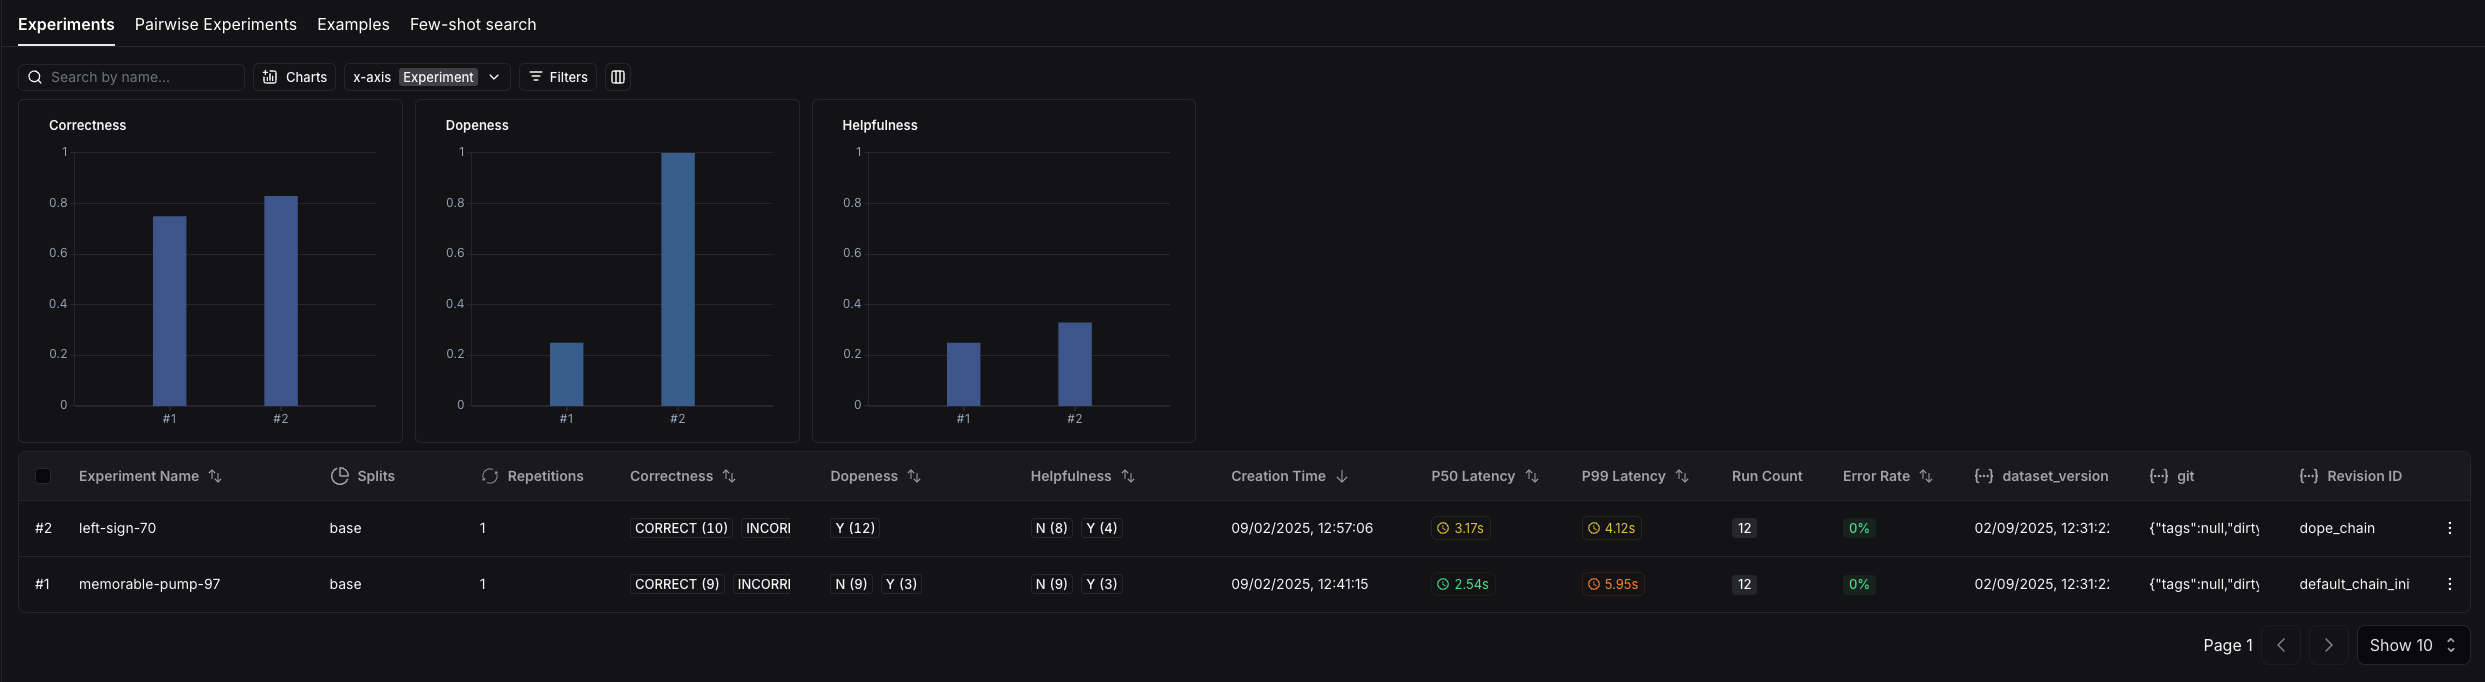




We can analyze how different metrics changed and why:

### **1. Correctness**  
- Experiment **#2 (left-sign-70)** has a slightly higher correctness score than **#1 (memorable-pump-97)**.  
- This suggests that **#2 is generating more factually accurate responses**.  
- Possible reason: The underlying retrieval method, LLM prompts, or embeddings may have improved, leading to better precision.

### **2. Dopeness**  
- Experiment **#2** has a significantly higher "Dopeness" score than **#1**.  
- This suggests that responses from **#2 are perceived as more engaging, stylish, or compelling**.  
- Possible reason: A change in prompt structure, model tuning, or response formatting to make outputs more expressive.

### **3. Helpfulness**  
- Experiment **#2** has a slightly better helpfulness score than **#1**, but both are relatively low.  
- This suggests **both experiments may struggle to fully assist the user** with useful responses.  
- Possible reason: The evaluation criteria for helpfulness might be strict, or the model isn't sufficiently grounding its responses in useful, actionable information.

### **4. Latency (P50 & P99)**  
- **#1 has a lower P50 (2.54s) but a higher P99 (5.95s)** compared to **#2 (P50: 3.17s, P99: 4.12s)**.  
- Possible reason:  
  - **#1 may have more variation in response times**, with occasional slow queries.  
  - **#2 has more stable latency but is slightly slower overall**, likely due to a more complex retrieval or processing mechanism.

### **Key Takeaways**  
- **#2 outperforms #1 in correctness, dopeness, and helpfulness**, but it has slightly higher latency.  
- **Dopeness improved significantly**, which suggests a more engaging response style.  
- **Correctness and helpfulness have improved, but helpfulness is still relatively low**, meaning there might be room for better grounding or summarization.
